In [1]:
import jax

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import trange

from lib.gd import wasserstein_gradient_descent, wasserstein_gradient_descent_lbfgs
from lib.mmd import target_value_and_grad_gaussian, target_value_and_grad_gaussian_by_hand, \
                    target_value_and_grad_laplace, target_value_and_grad_imq, target_value_and_grad_riesz

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Rings

In [2]:
def _generate_data():
    """
        From https://github.com/pierreglaser/kale-flow
    """
    N, r, _delta = 80, 0.3, 0.5
    
    X = np.c_[r * np.cos(np.linspace(0, 2 * np.pi, N + 1)), r * np.sin(np.linspace(0, 2 * np.pi, N + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = np.r_[X, X[:N, :]-i*np.array([0, (2 + _delta) * r])]

    rs = np.random.RandomState(42)
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([r/np.sqrt(2), r/np.sqrt(2)])
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([0, r])

    return X, Y


def plot_rings(L, X, title=None):
    f, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

    m = L[0].shape[0]
    
    for i, k in enumerate([0, 2, 25, 50]):
        axs[0, i].scatter(X[:,0],X[:,1],label="Target")
        for j in range(m):
            axs[0, i].scatter(L[k][j,:,0],L[k][j,:,1])
        axs[0, i].set_title("Iter "+str(k))
        axs[0, i].axis("off")
        axs[0, i].set_xlim([-1.9, 0.4])
        axs[0, i].set_ylim([-0.8, 0.8])
        
    for i, k in enumerate([100, 200, 250, 500]):
        axs[1, i].scatter(X[:,0],X[:,1],label="Target")
        for j in range(m):
            axs[1, i].scatter(L[k][j,:,0],L[k][j,:,1])
        axs[1, i].set_title("Iter "+str(k))
        axs[1, i].axis("off")
        axs[1, i].set_xlim([-1.9, 0.4])
        axs[1, i].set_ylim([-0.8, 0.8])
        
    axs[0, 0].legend()

    if title is not None:
        plt.suptitle(title)
    plt.show()

In [3]:
X, Y = _generate_data()
X = np.concatenate([X[:,1][:,None], X[:,0][:,None]], axis=-1)
Y = np.concatenate([Y[:,1][:,None], Y[:,0][:,None]], axis=-1)

In [4]:
X_data = np.zeros((3, 80, 2))
X_data[0] = X[:80]
X_data[1] = X[80:160]
X_data[2] = X[160:]

x0 = np.zeros((3, 80, 2))
x0[0] = Y[:80]
x0[1] = Y[80:160]
x0[2] = Y[160:]

# Gradient Flows of MMD

## Gaussian SW Kernel

Here, we use a MMD target with the Gaussian SW kernel [1,2]
\begin{equation}
    K(\mu,\nu) = e^{-\frac{SW_2^2(\mu,\nu)}{2h}}.
\end{equation}

[1] Kolouri, Soheil, Yang Zou, and Gustavo K. Rohde. "Sliced Wasserstein kernels for probability distributions." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2016.

[2] Meunier, Dimitri, Massimiliano Pontil, and Carlo Ciliberto. "Distribution regression with sliced Wasserstein kernels." International Conference on Machine Learning. PMLR, 2022.

In [5]:
## Gradient with autodiff

rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)

n_epochs = 501
L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, jax.jit(target_value_and_grad_gaussian), key, n_epochs=n_epochs, lr=0.1)

100%|██████████| 501/501 [00:04<00:00, 124.35it/s, loss = 0.000] 


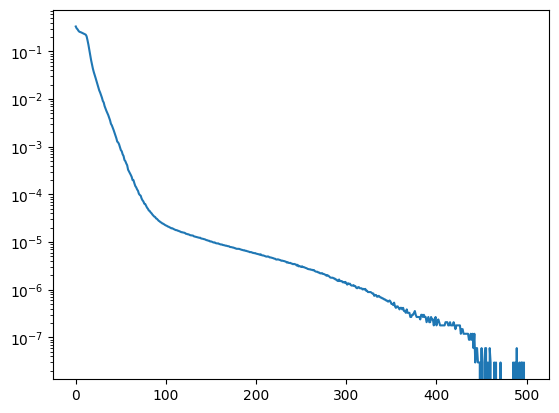

In [6]:
plt.plot(L_loss)
plt.yscale("log")
plt.show()

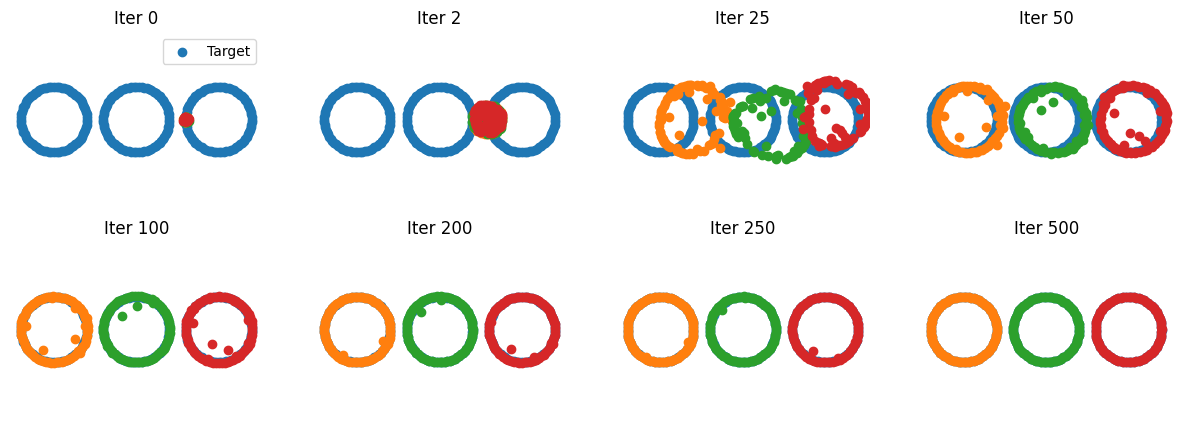

In [7]:
plot_rings(L_particles, X)

In [8]:
## Gradient by hand
rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)    

n_epochs = 501
L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, jax.jit(target_value_and_grad_gaussian_by_hand), key, n_epochs=n_epochs, lr=0.1)

100%|██████████| 501/501 [00:04<00:00, 119.70it/s, loss = 0.000] 


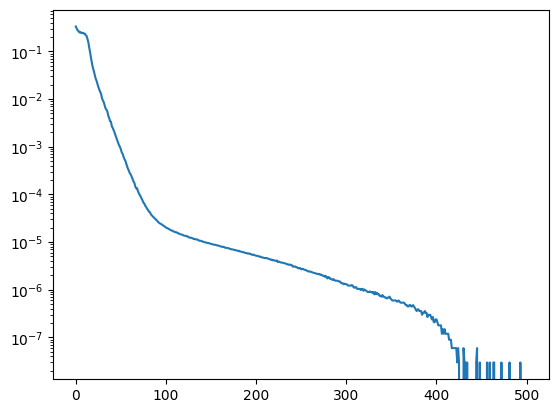

In [9]:
plt.plot(L_loss)
plt.yscale("log")
plt.show()

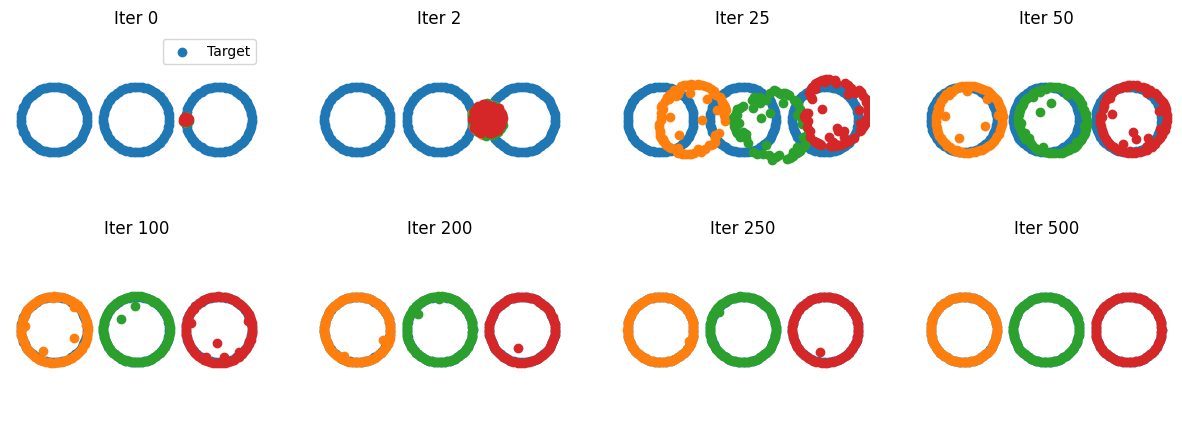

In [10]:
plot_rings(L_particles, X)

### Ablation

100%|██████████| 501/501 [00:03<00:00, 147.65it/s, loss = 0.215]


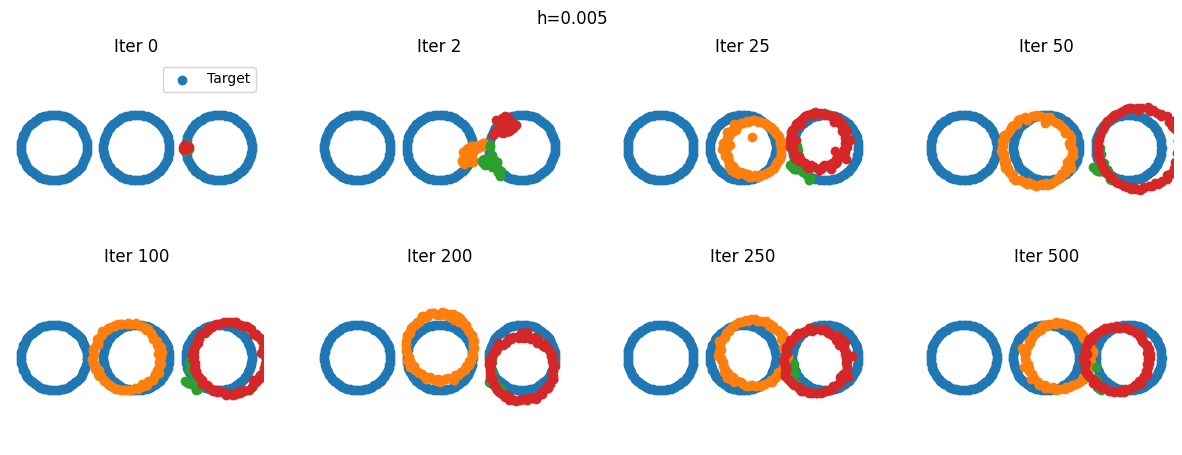

100%|██████████| 501/501 [00:03<00:00, 134.98it/s, loss = 0.090]


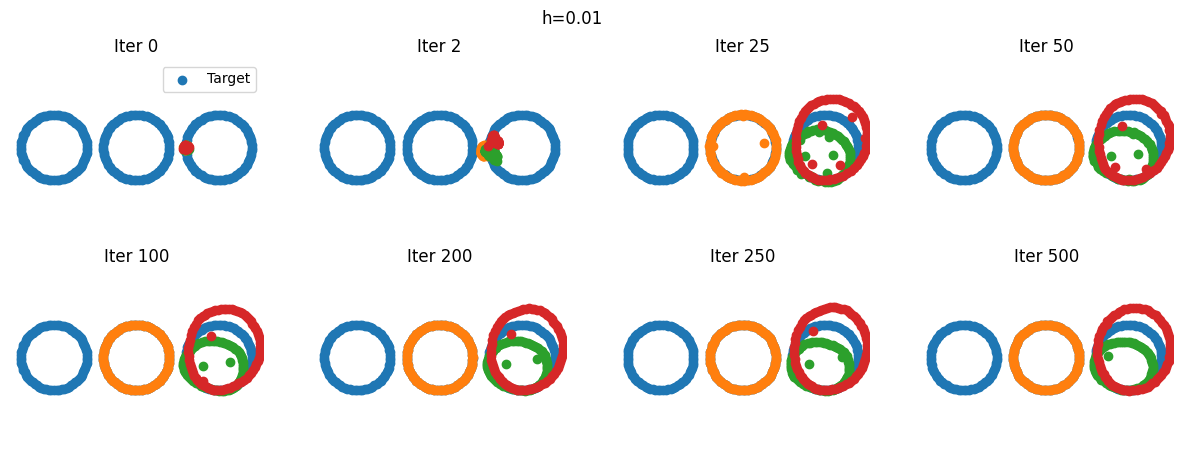

100%|██████████| 501/501 [00:03<00:00, 144.20it/s, loss = 0.000] 


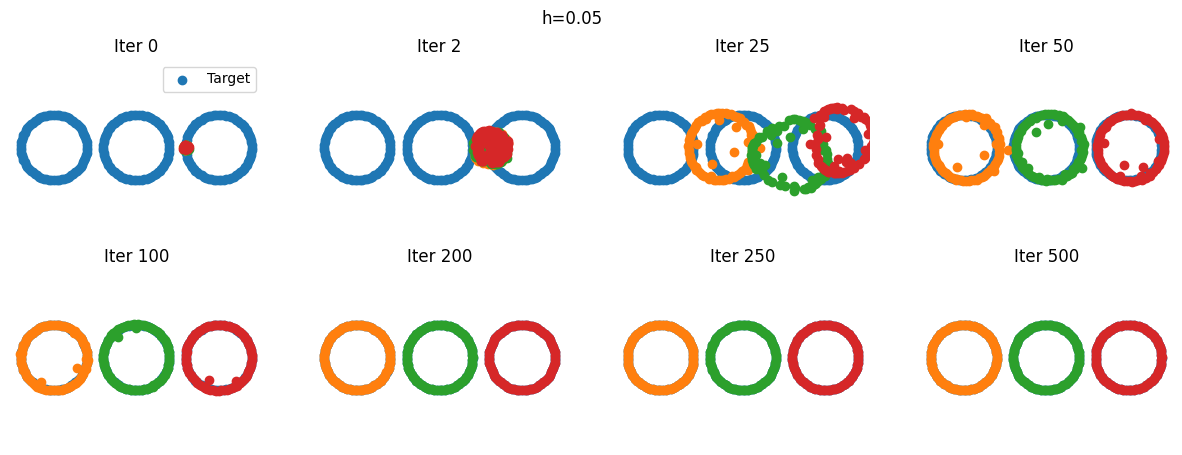

100%|██████████| 501/501 [00:02<00:00, 167.65it/s, loss = 0.000] 


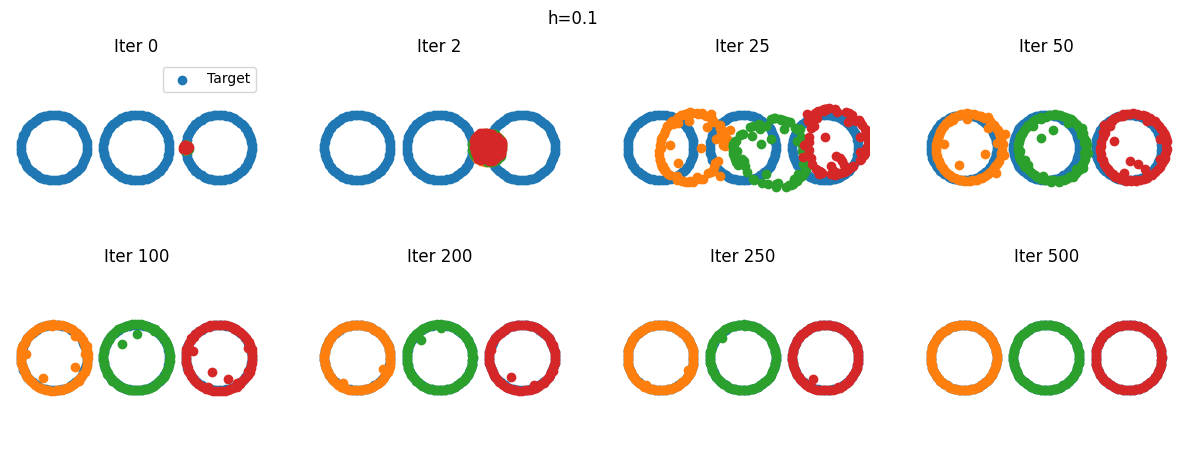

100%|██████████| 501/501 [00:03<00:00, 146.50it/s, loss = 0.000]


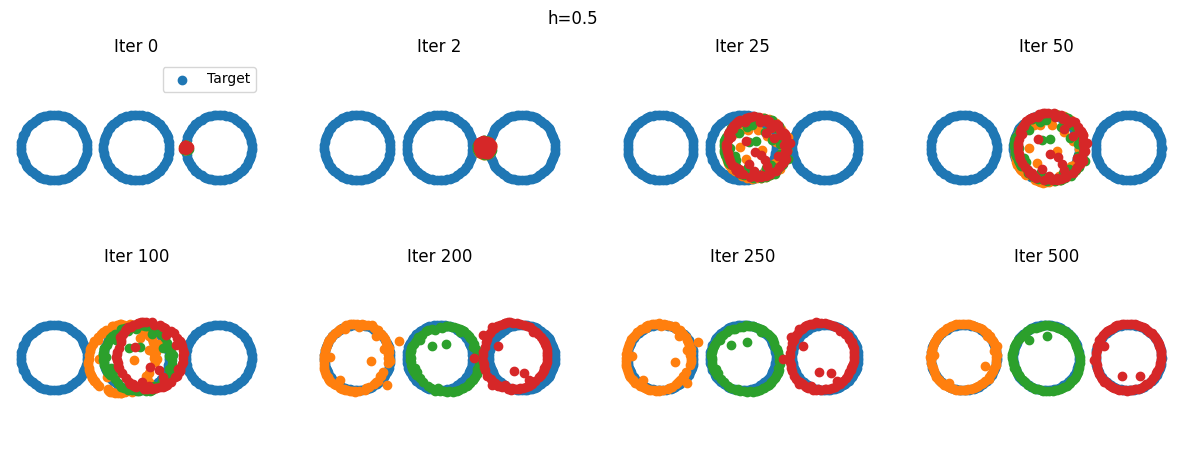

100%|██████████| 501/501 [00:03<00:00, 142.85it/s, loss = 0.002]


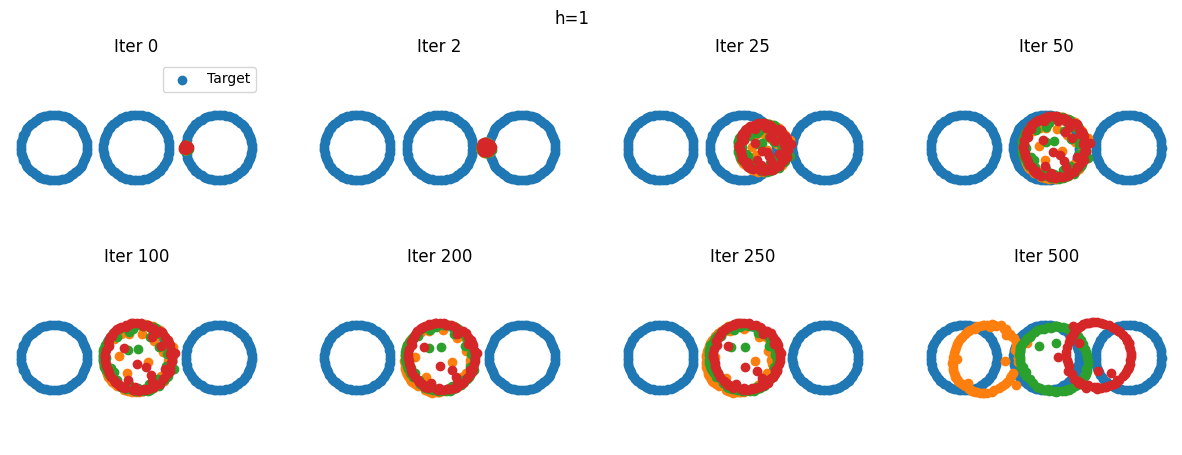

In [11]:
## Ablation h

hs = [0.005, 0.01, 0.05, 0.1, 0.5, 1]
n_epochs = 501

for h in hs:
    rng = jax.random.PRNGKey(0)
    master_key, key = jax.random.split(rng, num=2)

    target_grad = jax.jit(lambda x, y, key: target_value_and_grad_gaussian(x, y, key, h=h))
    L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, target_grad, key, n_epochs=n_epochs, lr=0.1)

    plot_rings(L_particles, X, title="h="+str(h))

## Laplace $SW$ kernel

Here, we use a MMD target with the Laplace SW kernel [1]
\begin{equation}
    K(\mu,\nu) = e^{-SW_1(\mu,\nu)/h}.
\end{equation}

[1] Meunier, Dimitri, Massimiliano Pontil, and Carlo Ciliberto. "Distribution regression with sliced Wasserstein kernels." International Conference on Machine Learning. PMLR, 2022.

In [12]:
rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)

n_epochs = 501
L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, jax.jit(target_value_and_grad_laplace), key, n_epochs=n_epochs, lr=0.1)

100%|██████████| 501/501 [00:03<00:00, 142.64it/s, loss = 0.010]


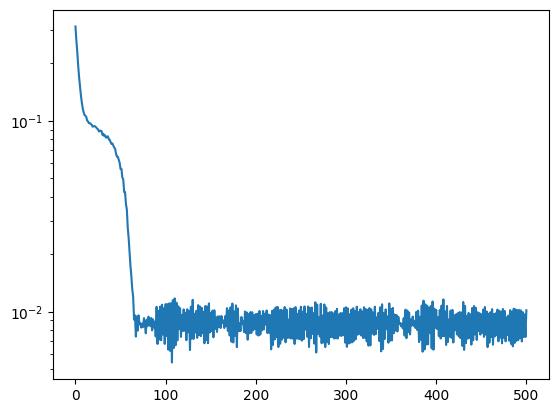

In [13]:
plt.plot(L_loss)
plt.yscale("log")
plt.show()

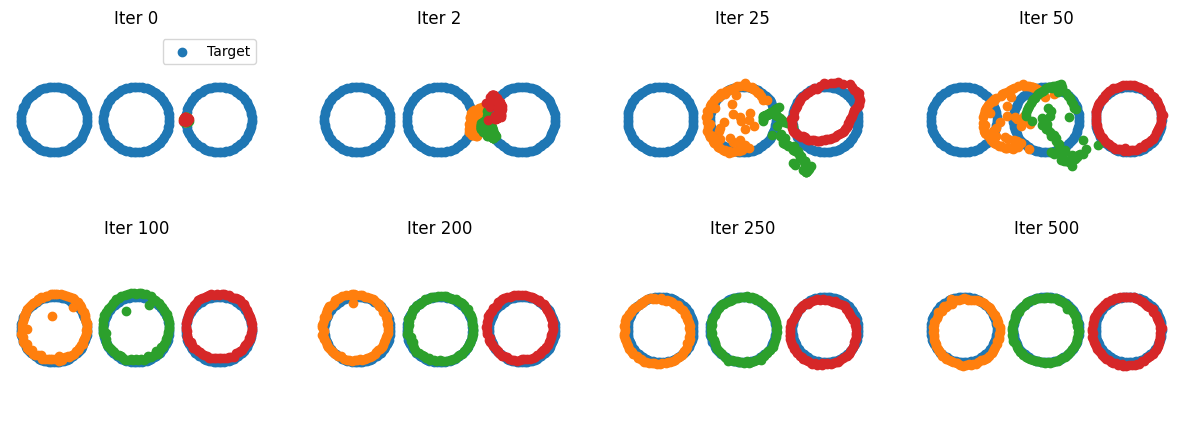

In [14]:
plot_rings(L_particles, X)

100%|██████████| 501/501 [00:03<00:00, 138.41it/s, loss = 0.333]


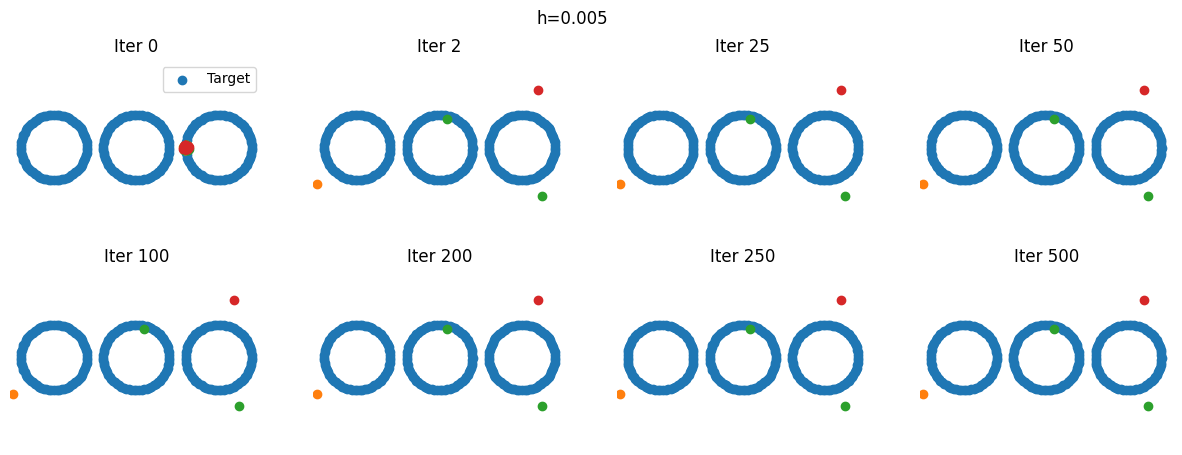

100%|██████████| 501/501 [00:03<00:00, 136.21it/s, loss = 0.333]


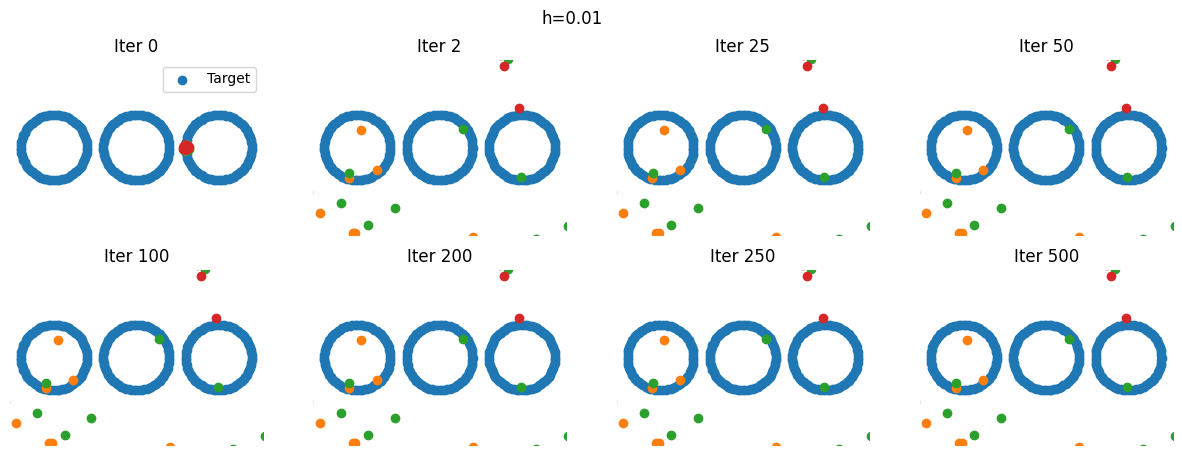

100%|██████████| 501/501 [00:03<00:00, 139.33it/s, loss = 0.242]


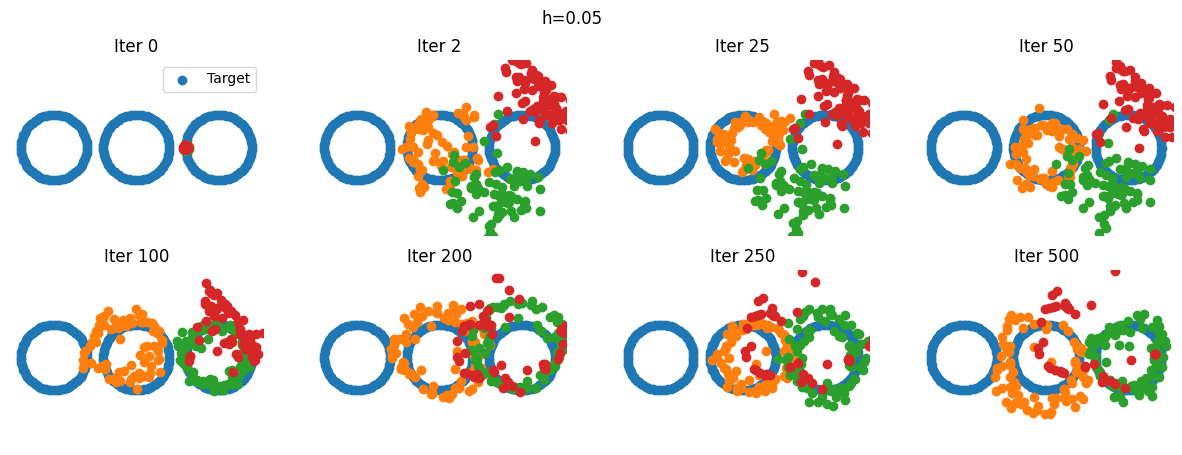

100%|██████████| 501/501 [00:03<00:00, 133.61it/s, loss = 0.171]


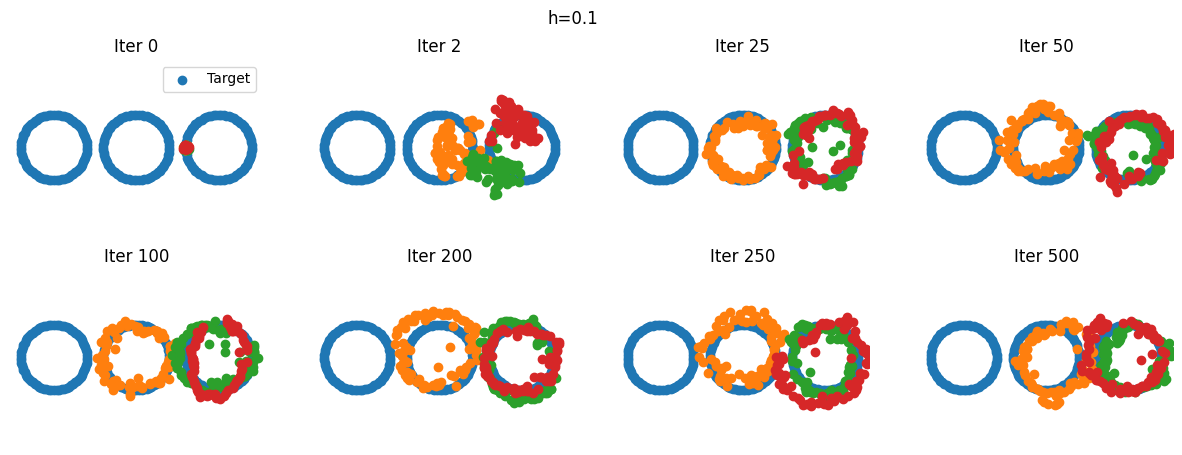

100%|██████████| 501/501 [00:03<00:00, 153.93it/s, loss = 0.007]


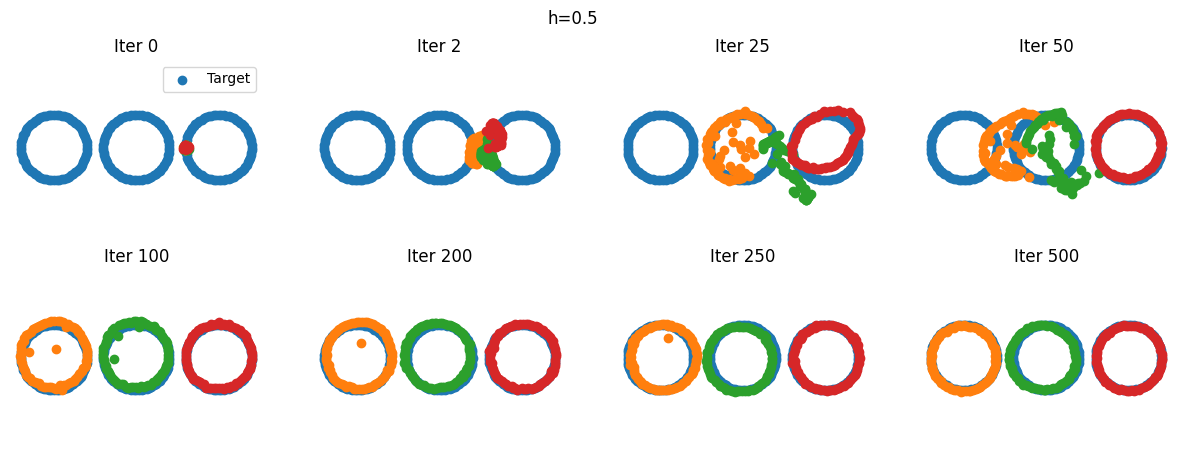

100%|██████████| 501/501 [00:03<00:00, 144.15it/s, loss = 0.003]


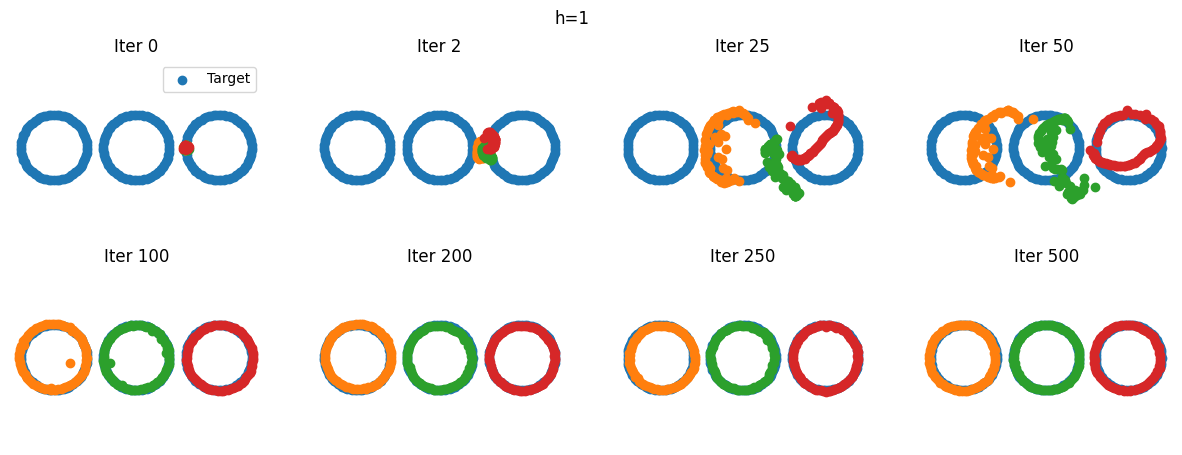

In [15]:
## Ablation h

hs = [0.005, 0.01, 0.05, 0.1, 0.5, 1]
n_epochs = 501

for h in hs:
    rng = jax.random.PRNGKey(0)
    master_key, key = jax.random.split(rng, num=2)
    
    target_grad = jax.jit(lambda x, y, key: target_value_and_grad_laplace(x, y, key, h=h))
    L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, target_grad, key, n_epochs=n_epochs, lr=0.1)

    plot_rings(L_particles, X, title="h="+str(h))

## IMQ SW Kernel?

Kernel of the form
\begin{equation}
    K(\mu,\nu) = \frac{1}{\sqrt{c + SW_2^2(\mu,\nu)}}.
\end{equation}

In [16]:
h = 0.05

rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)

target_grad = jax.jit(lambda x, y, key: target_value_and_grad_imq(x, y, key, h=h))

n_epochs = 501
L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, target_grad, key, n_epochs=n_epochs, lr=0.1)

100%|██████████| 501/501 [00:03<00:00, 139.93it/s, loss = 0.000] 


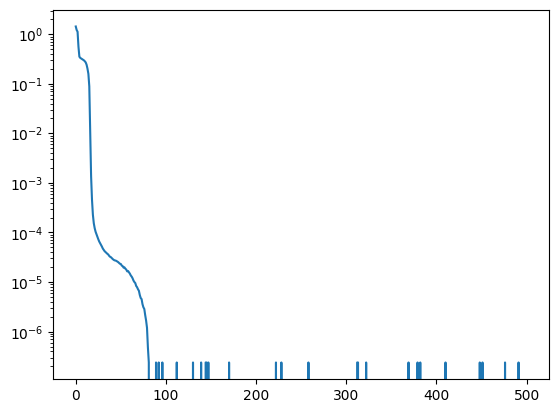

In [17]:
plt.plot(L_loss)
plt.yscale("log")
plt.show()

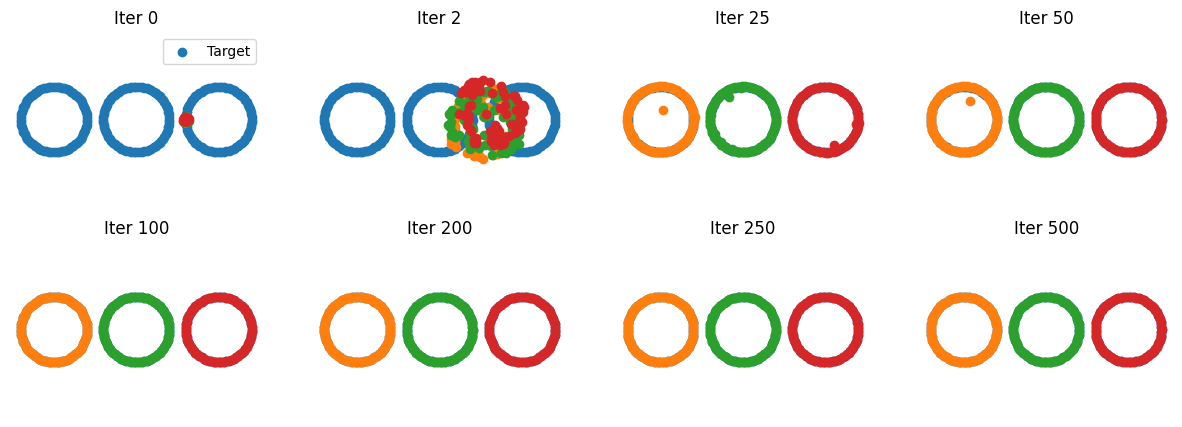

In [18]:
plot_rings(L_particles, X)

100%|██████████| 501/501 [00:03<00:00, 140.39it/s, loss = 4.291]


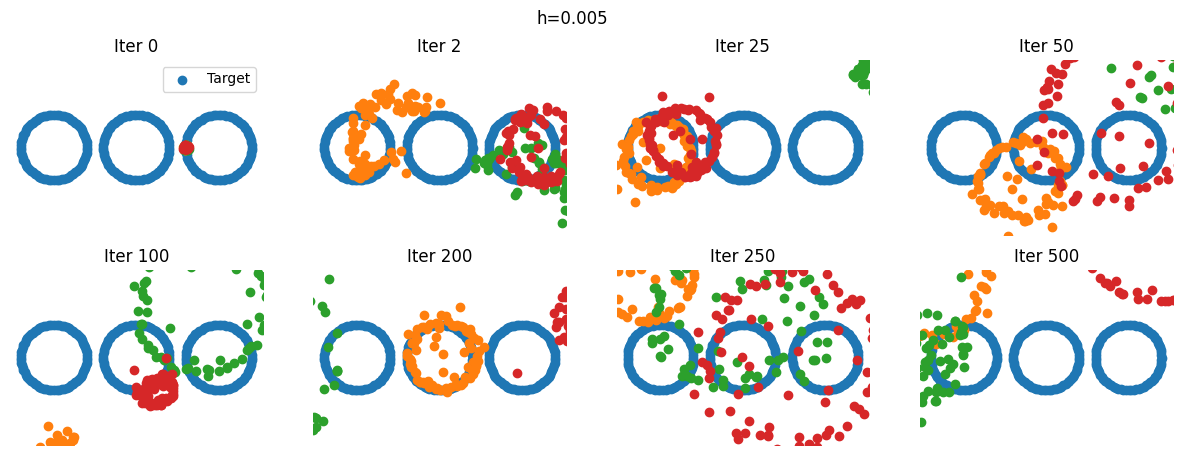

100%|██████████| 501/501 [00:03<00:00, 137.47it/s, loss = 1.682]


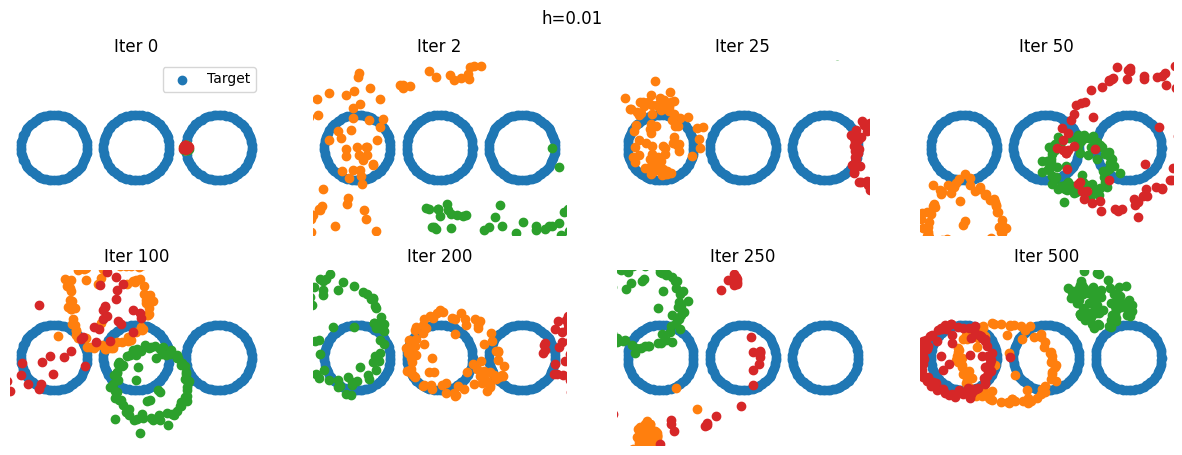

100%|██████████| 501/501 [00:03<00:00, 161.64it/s, loss = 0.000] 


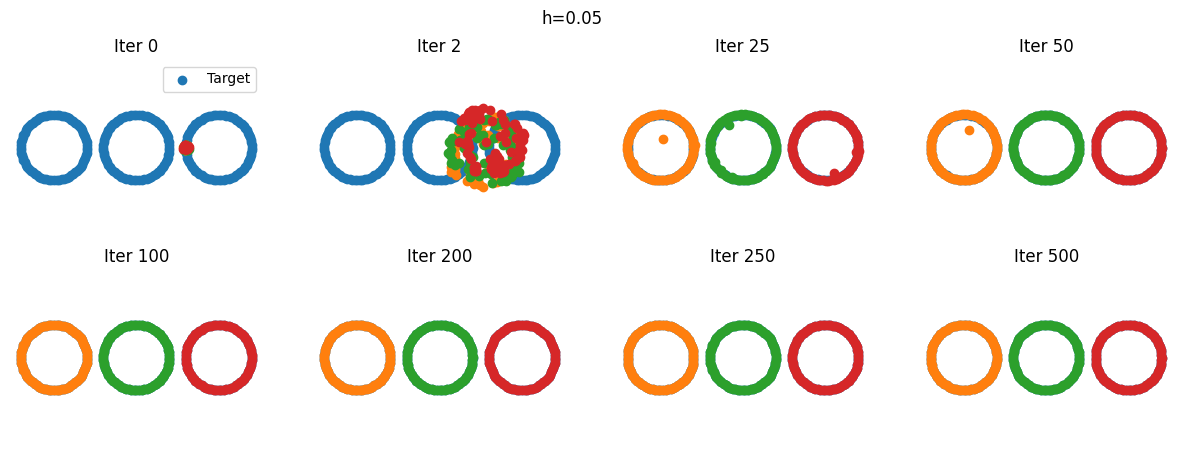

100%|██████████| 501/501 [00:03<00:00, 134.62it/s, loss = 0.000] 


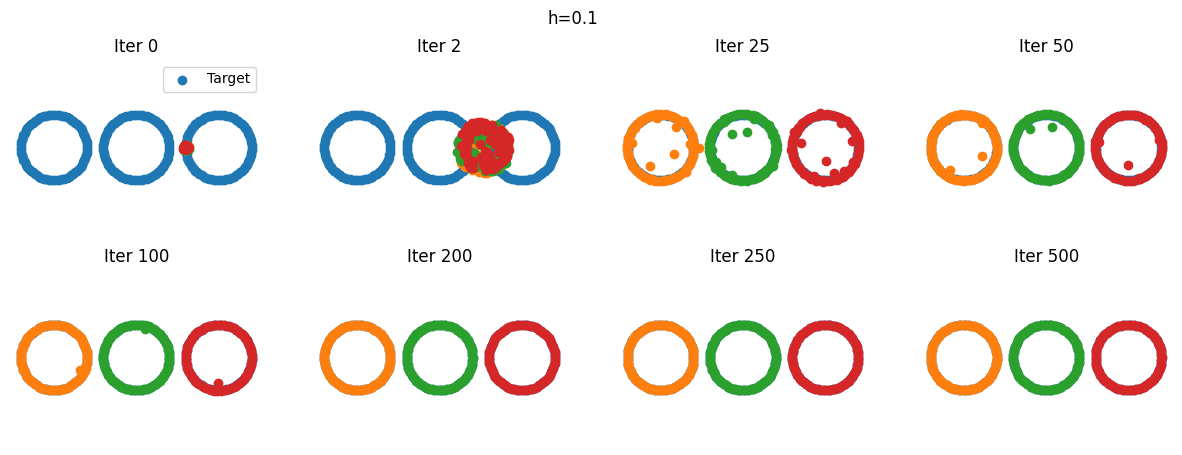

100%|██████████| 501/501 [00:03<00:00, 142.66it/s, loss = 0.000]


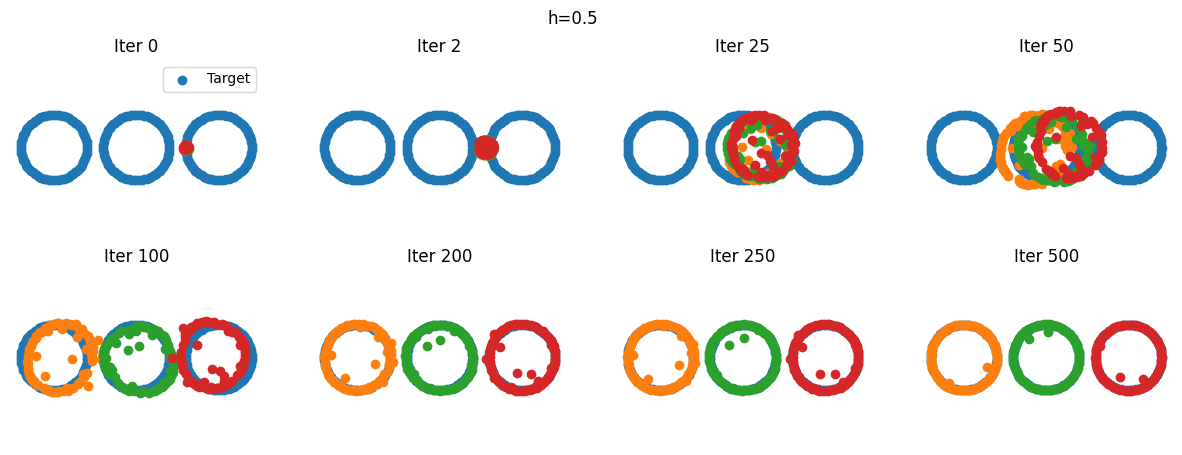

100%|██████████| 501/501 [00:03<00:00, 140.87it/s, loss = 0.000]


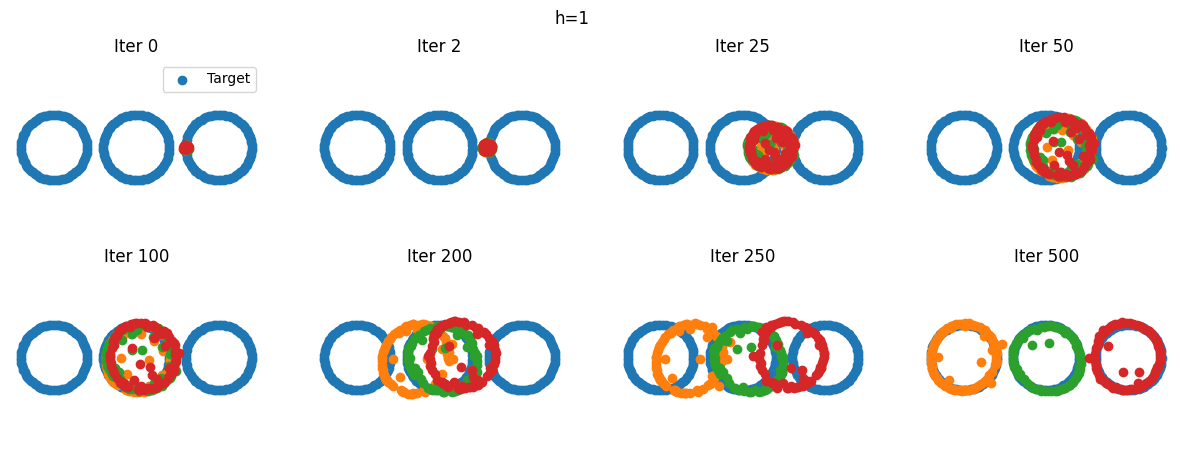

In [19]:
## Ablation h

hs = [0.005, 0.01, 0.05, 0.1, 0.5, 1]
n_epochs = 501

for h in hs:
    rng = jax.random.PRNGKey(0)
    master_key, key = jax.random.split(rng, num=2)
    
    target_grad = jax.jit(lambda x, y, key: target_value_and_grad_imq(x, y, key, h=h))
    L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, target_grad, key, n_epochs=n_epochs, lr=0.1)

    plot_rings(L_particles, X, title="h="+str(h))

## Riesz $SW$ kernel

Kernel: $K(\mu,\nu) = -SW_2^r(\mu,\nu)$.

In [20]:
rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)

n_epochs = 501
L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, jax.jit(target_value_and_grad_riesz), key, n_epochs=n_epochs, lr=0.1)

100%|██████████| 501/501 [00:03<00:00, 139.78it/s, loss = 0.003]


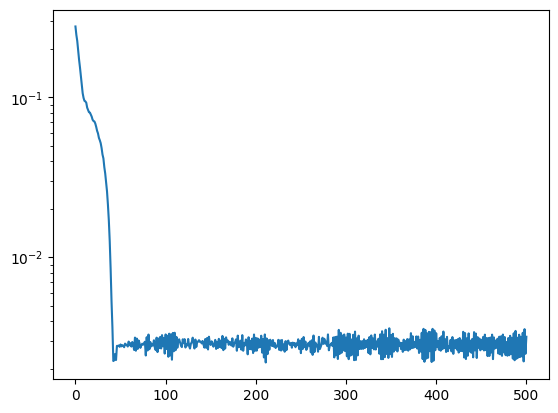

In [21]:
plt.plot(L_loss)
plt.yscale("log")
plt.show()

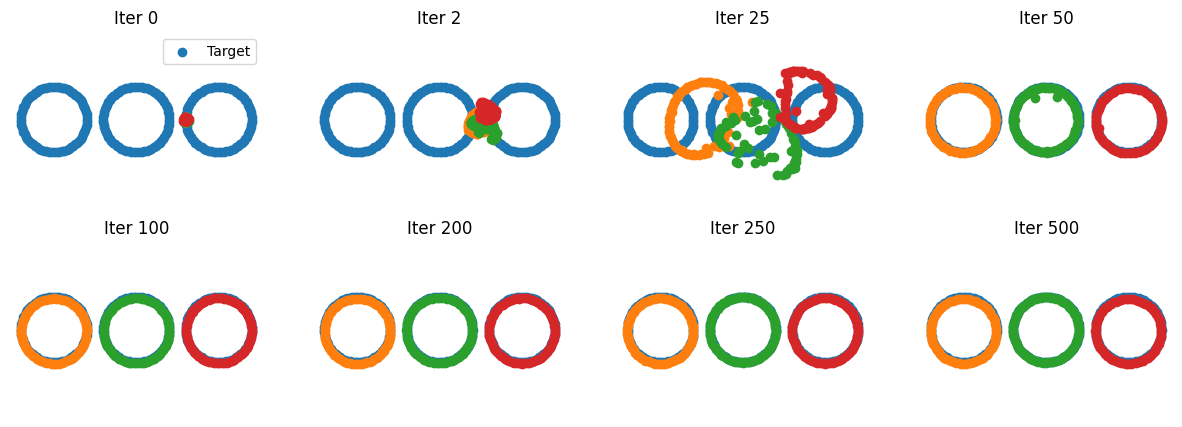

In [22]:
plot_rings(L_particles, X)

100%|██████████| 501/501 [00:03<00:00, 137.62it/s, loss = 0.044]


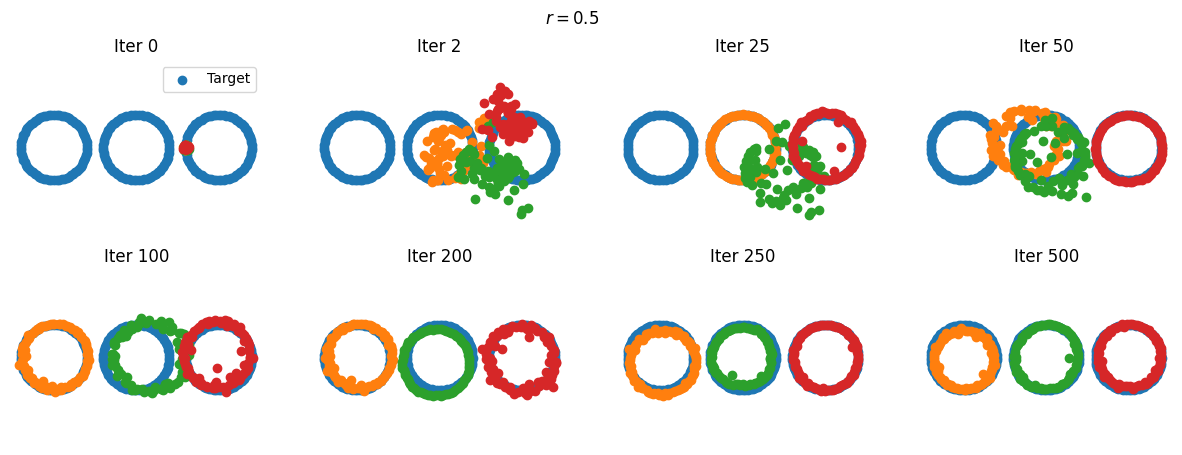

100%|██████████| 501/501 [00:03<00:00, 162.68it/s, loss = 0.003]


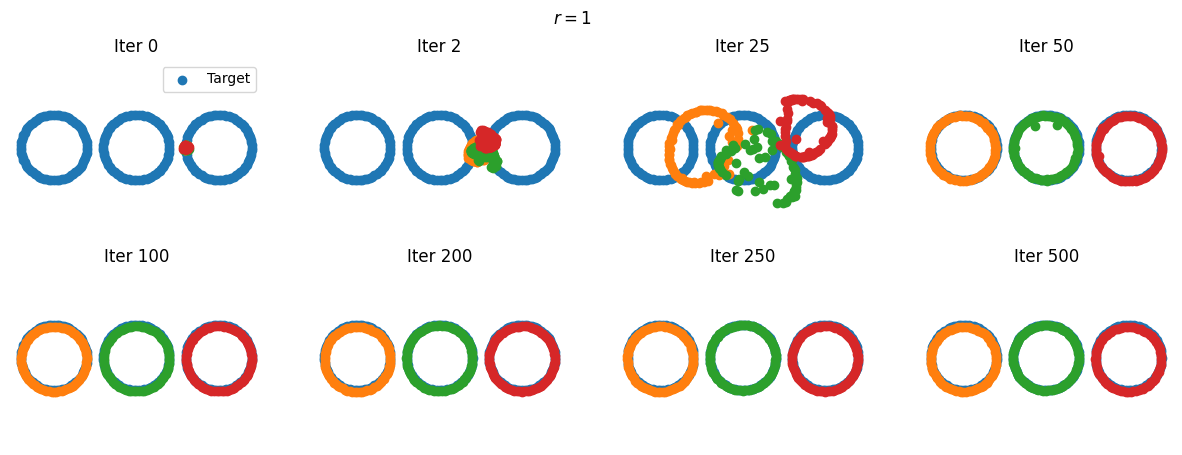

100%|██████████| 501/501 [00:03<00:00, 137.00it/s, loss = 0.000]


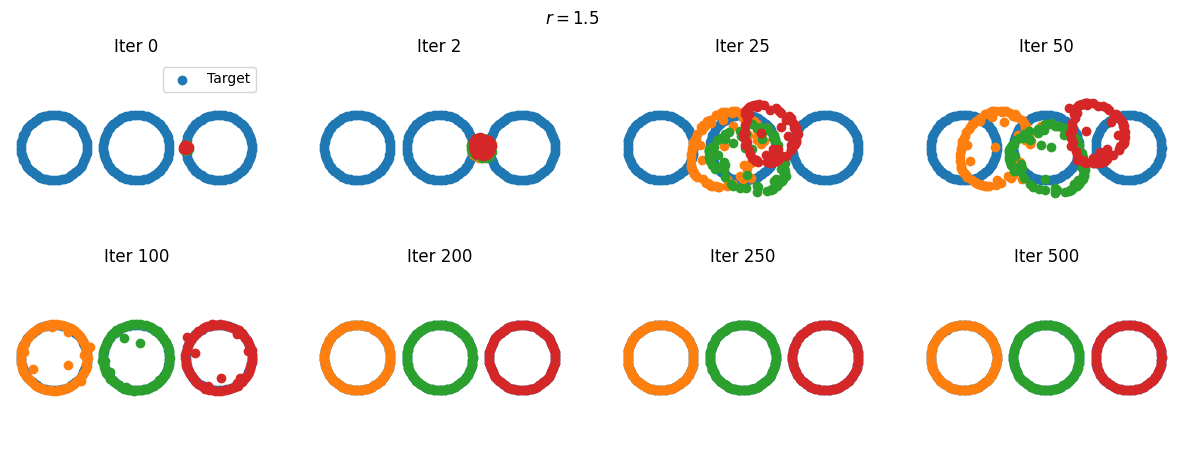

In [23]:
n_epochs = 501

for r in [0.5, 1, 1.5]:
    rng = jax.random.PRNGKey(0)
    master_key, key = jax.random.split(rng, num=2)
    
    target_grad = jax.jit(lambda x, y, key: target_value_and_grad_riesz(x, y, key, r=r))
    
    L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, target_grad, key, n_epochs=n_epochs, lr=0.1)
    plot_rings(L_particles, X, title=r"$r=$"+str(r))

### Test Momentum

100%|██████████| 251/251 [00:13<00:00, 19.11it/s, loss = 0.000]


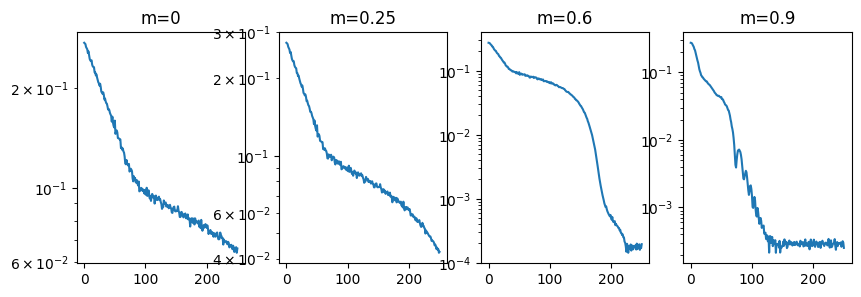

In [31]:
rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)

n_epochs = 251

fig, ax = plt.subplots(1, 4, figsize=(10,3))

for i, m in enumerate([0,0.25,0.6,0.9]):
    L_loss, L_particles = wasserstein_gradient_descent(x0, X_data, target_value_and_grad_riesz, key, n_epochs=n_epochs, lr=0.01, m=m)

    ax[i].plot(L_loss)
    ax[i].set_title("m="+str(m))
    ax[i].set_yscale("log")

# L_loss, L_particles = wasserstein_gradient_descent_lbfgs(x0, X_data, target_value_and_grad_riesz, key, n_epochs=n_epochs, lr=0.01)
# ax[4].plot(L_loss)
# ax[4].set_title("lbfgs")
# ax[4].set_yscale("log")

plt.show()